In [2]:
# import and solve data
from pandas import read_csv
import numpy as np
from matplotlib import pyplot as plt
from numpy import mean, min, max, median, quantile
from scipy.stats import binom, norm, t as student, expon
from math import sqrt, pow, floor, ceil, exp

# define corrected functions for std and variance
def variance(values):
    return np.var(values, ddof=1)

def std(values):
    return np.std(values, ddof=1)

data = 'data'
data_ex1 = read_csv(f'{data}\\data_ex1.csv', header=None)
data_ex2 = read_csv(f'{data}\\data_ex2.csv', header=None)

# EXERCISE 1
# Load the data from the CSV file data_ex1.csv. This data represents measurements of some quantity over a few days.
# In each line: the 1st value refers to the time of the measurement; the 2nd value is the measurement output.
# If you draw a scatter plot, you should see a clear trend in the data.
# 1. Use least squares to remove the trend. You only need polynomial functions for this.
# 2. After having verified that a good value for the maximum degree of the the polynomial is 5, remove the
# trend from the data and fit a Gaussian distribution to the resulting dataset.
# 3. Give the mean and variance of the distribution, and draw a QQ-plot to determine if the Gaussian approximation holds. Give a prediction interval for future samples from this Gaussian distribution.
# 4. Discuss what would happen if you fit a polynomial of degree different than 5 to the data.
values = data_ex1.to_numpy()
# print(values)
X = values[:,0]
Y = values[:,1]
a, b, c, d, e, f = np.polyfit(X, Y, 5)
# plt.scatter(X, Y, s=2)
# plt.show()

def polyfit(X, Y, degree):
    # return coefficients from high degree to low
    A = []
    for power in range(degree+1):
        A.append(np.power(X,power))
    A = np.array(A)
    A = np.transpose(A)
    A_t = np.transpose(A)
    b = np.linalg.inv(A_t @ A) @ A_t @ Y
    return np.flip(b)

# plt.scatter(X, Y, s=0.2)
for i in range(1,10):
    coeff = polyfit(X,Y,i)
    Y_fit = np.poly1d(coeff)(X)
    mean_square_error = sum(np.power(Y-Y_fit,2))/len(X)
    # print(i, mean_square_error)
    #plt.scatter(X, Y_fit, s=1)
    # plt.scatter(X, Y-np.poly1d(coeff)(X), s=1)
    # plt.show()
# plt.show()

coeff = polyfit(X,Y,5)
Y_detr = Y-np.poly1d(coeff)(X)
# plt.scatter(X, Y_detr, s=1)
# plt.show()


print(f'Std: {std(Y_detr)}, mean: {mean(Y_detr)}')
# plt.hist(Y_detr, bins=50, density=True, color='y', linewidth=0.1, edgecolor='b')
X_prob = np.arange(min(Y_detr), max(Y_detr), 1/100)
# plt.scatter(X_prob, norm.pdf(X_prob, mean(Y_detr), std(Y_detr) ), s=1, zorder=2)
# plt.show()


X = []
Y = []
values = sorted(Y_detr)
n = len(values)
for i in np.arange(0,n,1):
    X.append(norm.ppf((i+1)/(n+1)))
    Y.append(values[i])
X = np.array(X)
Y = np.array(Y)
m, b = np.polyfit(X, Y, 1)
# plt.scatter(X, Y, s=2)
# plt.plot([X[0],X[-1]], [m*X[0]+b, m*X[-1]], 'r--')
# plt.show()

def prediction_interval_bootstrap(values, gamma):
    values = sorted(values)
    alpha = 1-gamma
    j = floor(n*alpha/2)
    k = ceil(n*(1-alpha/2))
    return (values[j], values[k])

def prediction_interval_normal(values, gamma):
    values = sorted(values)
    n = len(values)
    alpha = 1-gamma
    m = mean(values)
    s = std(values)
    if n > 100:
        eta = norm.ppf(1-alpha/2)
        return (m-eta*s, m+eta*s)
    else:
        eta = student.ppf(1-alpha/2, n-1)
        rt = sqrt(1 + 1/n)
        return (m-eta*rt*s, m+eta*rt*s)


interval = prediction_interval_bootstrap(values, 0.95)
print(f"Bootstrap prediction interval at 0.95: [{interval[0]} , {interval[1]}]")
interval = prediction_interval_normal(values, 0.95)
print(f"Normal prediction interval at 0.95: [{interval[0]} , {interval[1]}]")

Std: 1.9979805596097109, mean: -5.392509194734885e-11
Bootstrap prediction interval at 0.95: [-3.9254280790052984 , 3.9637993750276515]
Normal prediction interval at 0.95: [-3.9159699387001417 , 3.915969938592291]


prior true
[(1.4489124071219661, 1.4084996861560852, 0.45725213109252305), (8.940479778916423, 2.151350691924647, 0.5388891118083721)]


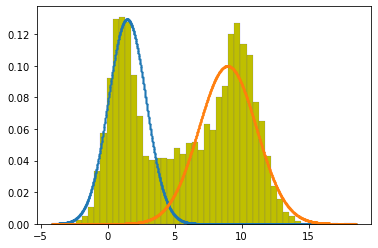

prior false
[(1.6050863438510377, 1.5554974116546059, 0.5), (9.094046954947213, 2.026752739005223, 0.5)]


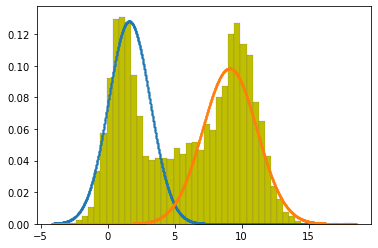

In [11]:
# Exercise 2
# Load the data from the CSV file data_ex2.csv. These are samples from three different, independent Gaussian
# distributions, all mixed together.
# 1. Implement the Expectation-Maximization algorithm to fit a mixture of three Gaussian distributions to the data.
#    Try both with and without the prior update step. Discuss the results.
# 2. Give the parameters of the distributions thus found, and plot the corresponding PDFs on top of the
#    empirical PDFs of the data (e.g., the histogram).

values = data_ex2.to_numpy()[:,0]

def expectation_maximization_normal(values, curve_n, iterations, curve_prob=None, prior=True):
    n = len(values)
    # use the same std for all of them
    deviations = [std(values)]*curve_n
    # for 3 curves, use 1/4, 2/4, 3/4 quantiles as means
    means = [quantile(values, (i+1)/(curve_n+1)) for i in range(curve_n)]
    if curve_prob==None:
        curve_prob = [1/curve_n]*curve_n
    #print([(means[i], deviations[i], curve_prob[i]) for i in range(curve_n)])

    for iteration in range(iterations):
        denoms = np.zeros(n)
        for curve in range(curve_n):
            denoms += norm.pdf(values, means[curve], deviations[curve])*curve_prob[curve]
            
        for curve in range(curve_n):
            m = means[curve]
            s = deviations[curve]
            b = norm.pdf(values,m,s)/denoms
            sum_b = sum(b)
            new_m = sum(b*values) / sum_b
            new_s = sqrt( sum(b*((values-new_m)**2)) / sum_b )
            means[curve] = new_m
            deviations[curve] = new_s
            if prior:
                curve_prob[curve] = sum_b
        #print([(means[i], deviations[i], curve_prob[i]) for i in range(curve_n)])

    return [(means[i], deviations[i], curve_prob[i]) for i in range(curve_n)]

iterations = 1000
print("prior true")
curves = expectation_maximization_normal(values, 3, iterations, prior=True)
print(curves)
plt.hist(values, bins=50, density=True, color='y', linewidth=0.1, edgecolor='b')
X_prob = np.arange(min(values), max(values), 1/100)
for c in curves:
    plt.scatter(X_prob, c[2]*norm.pdf(X_prob, c[0], c[1] ), s=1, zorder=2)
plt.show()

print("prior false")
curves = expectation_maximization_normal(values, 3, iterations, prior=False)
print(curves)
plt.hist(values, bins=50, density=True, color='y', linewidth=0.1, edgecolor='b')
X_prob = np.arange(min(values), max(values), 1/100)
for c in curves:
    plt.scatter(X_prob, c[2]*norm.pdf(X_prob, c[0], c[1] ), s=1, zorder=2)
plt.show()
